# Master project XENON100 LEC MAP
Cesium source

In [1]:
# Boilerplate startup code
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy
from scipy.stats import norm


In [2]:
%matplotlib inline 
matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

In [3]:
# Import the XENON100 configuration from pax
from pax.configuration import load_configuration
pax_config = load_configuration('XENON100')

In [4]:
import hax
hax.init(main_data_paths=['/home/xenon100ws/newcs']) #Folder containing the data

In [5]:
from pax import units

In [6]:
from IPython.core.display import Image

In [7]:
# Usefull minitree :
class AreaPerChannel(hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.area_per_channel*', 'peaks.n_saturated_per_channel*']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 
        s1 = event.peaks[event.interactions[0].s1]
        
        # Get the main interaction
        interaction = event.interactions[0]
        
        temp_dict = {}
        for channel, s1_area in enumerate(s1.area_per_channel):
            if (channel == 144) or (channel == 97) or (channel == 146) or (channel ==141) or (channel==82) or (channel == 75) or (channel== 60) or (channel == 70) or (channel==163) or (channel == 114) or (channel== 106) or (channel == 171) or (channel ==8) or (channel == 22) or (channel==1) or (channel==43) or (channel ==37) or (channel == 49) or (channel== 130) or (channel==140) or (channel==137) or (channel == 147): 
                temp_dict['s1_area_channel_%d' % channel] = s1_area
        return temp_dict

In [8]:
class R2 (hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
            
        # Get the main interaction
        interaction = event.interactions[0]
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(r2= interaction.x**2+interaction.y**2)

In [9]:
class Photopeak (hax.minitrees.TreeMaker):
    extra_branches = ['area']
    __version__ = '0.0.1' 
    
    # Cut data not in the photopeak, using cS1 and cS2_tot_bottom values determined in a other note
    # "MasterProjectCs137"
    
    def extract_data(self, event):
       
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main interaction
        interaction = event.interactions[0]
            
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        event_data=dict()
        if len(event.interactions) !=0:
            if (s1.area * interaction.s1_area_correction >750) &(s1.area * interaction.s1_area_correction <1600):
                event_data['newcs1']=s1.area * interaction.s1_area_correction
            
            if ((1-s2.area_fraction_top)*interaction.s2_area_correction*s2.area) > 2.5e5:
                event_data['newcs2']=((1-s2.area_fraction_top)*interaction.s2_area_correction*s2.area)
              
        return event_data
       

# Cesium data :

In [10]:
dataset=['test_data','pax_v410_xe100_110912_1809','pax_v410_xe100_110927_1949','pax_v410_xe100_110718_1511','pax_v410_xe100_110829_1516','pax_v410_xe100_110905_1435','pax_v410_xe100_110919_1747']


In [11]:
# use hax on our data
data = hax.minitrees.load(dataset, treemakers=[Photopeak,AreaPerChannel,'Basics'], force_reload=False)
print(len(data))

Found minitree at ./test_data_Photopeak.root
Found minitree at ./pax_v410_xe100_110912_1809_Photopeak.root
Found minitree at ./pax_v410_xe100_110927_1949_Photopeak.root
Found minitree at ./pax_v410_xe100_110718_1511_Photopeak.root
Found minitree at ./pax_v410_xe100_110829_1516_Photopeak.root
Found minitree at ./pax_v410_xe100_110905_1435_Photopeak.root
Found minitree at ./pax_v410_xe100_110919_1747_Photopeak.root
Found minitree at ./test_data_AreaPerChannel.root
Found minitree at ./pax_v410_xe100_110912_1809_AreaPerChannel.root
Found minitree at ./pax_v410_xe100_110927_1949_AreaPerChannel.root
Found minitree at ./pax_v410_xe100_110718_1511_AreaPerChannel.root
Found minitree at ./pax_v410_xe100_110829_1516_AreaPerChannel.root
Found minitree at ./pax_v410_xe100_110905_1435_AreaPerChannel.root
Found minitree at ./pax_v410_xe100_110919_1747_AreaPerChannel.root
Found minitree at ./test_data_Basics.root
Found minitree at ./pax_v410_xe100_110912_1809_Basics.root
Found minitree at ./pax_v410_x

In [12]:
def get_phi(x,y):
    if (x==0) and (y==0):
        return 0
    elif x >= 0:
        return np.arcsin(y/np.sqrt(x**2+y**2)) +np.pi/2
    elif x < 0:
        return - np.arcsin(y/np.sqrt(x**2+y**2)) + np.pi +np.pi/2
    

In [13]:
data['phi'] = np.array([get_phi(x,y) for x,y in zip(data['x'], data['y'])])

In [14]:
# cut data with newcs1 == nan
data= data[(data['newcs1']>0)&(data['newcs2']>0)]
print('Number of events =',len(data))

Number of events = 74503


In [15]:
data['r']=np.sqrt(data['x']**2+data['y']**2)

In [16]:
data.head(5)

,index,newcs1,newcs2,index,s1_area_channel_1,s1_area_channel_106,s1_area_channel_114,s1_area_channel_130,s1_area_channel_137,s1_area_channel_140,...,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z,phi,r
4,4,1158.293602,300753.909481,4,0.0,3.169986,3.029374,10.192683,4.210809,11.822699,...,3.403345,849.740295,0.255484,344215.21875,0.366078,6.929379,-0.901130,-6.002091,1.44148,6.987727
22,22,1098.850509,252778.134836,22,0.0,20.446175,16.610564,13.278718,17.802317,7.810788,...,0.000000,1073.199097,0.160233,270263.31250,0.366614,2.641243,9.601695,-15.863226,2.87315,9.958349
29,29,1147.021603,256758.503109,29,0.0,15.923173,20.612660,8.100842,16.188589,9.335491,...,4.594101,1247.790649,0.145457,318191.28125,0.349450,3.449152,7.612994,-18.272846,2.7162,8.357890
39,39,1113.680358,410072.850779,39,0.0,2.596414,10.023449,15.904634,10.693919,14.861531,...,37.444862,1063.908569,0.154182,326882.21875,0.373772,-0.652542,-13.144068,-17.921568,6.23358,13.160256
42,42,1180.467104,276985.478157,42,0.0,12.362228,20.846734,1.787417,29.568586,11.809240,...,0.000000,1143.417236,0.120380,272065.09375,0.373556,11.838983,3.324859,-20.330551,1.84458,12.296999


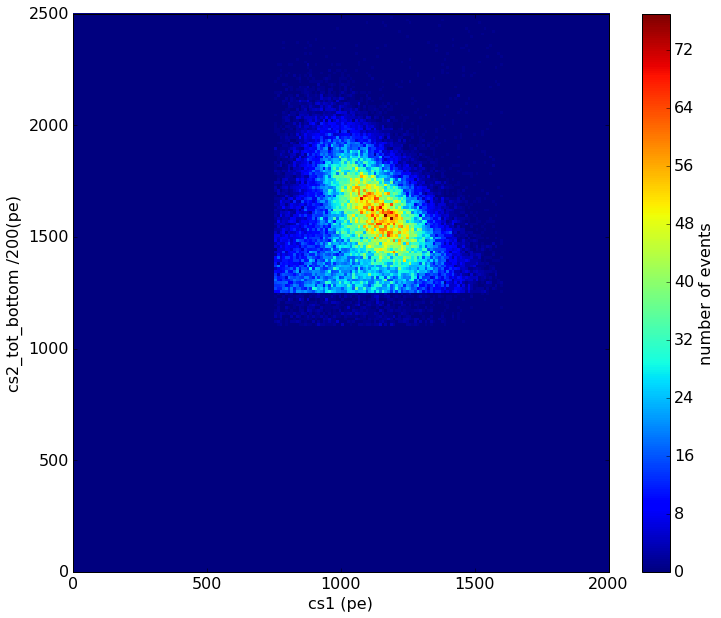

In [17]:
plt.hist2d(data['newcs1'],data['newcs2']/200, bins=200, range=[[0,2000],[0,2500]])
plt.colorbar(label='number of events')
plt.xlabel('cs1 (pe)')
plt.ylabel('cs2_tot_bottom /200(pe)')
plt.show()

In [18]:
new_cs2_tot_bottom = data['newcs2']
new_cs1 =data['newcs1']

# Combined Energy Scale (CES)
Erik's code

In [19]:
from pax import recarray_tools
from recarray_tools import filter_on_fields, group_by, append_fields
from tqdm import tqdm
from scipy.optimize import curve_fit
from pax.formats import flat_data_formats
file_format = 'hdf5'
ioformat = flat_data_formats[file_format]()

In [20]:
# Some functions that'll be used
def func_poly_2(x,a,b,c):
    return a + b*x + c*x**2
def func_exp(x,a,tau):
    return a*np.exp(-x/tau)
def func_gauss(x,A,mu,sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

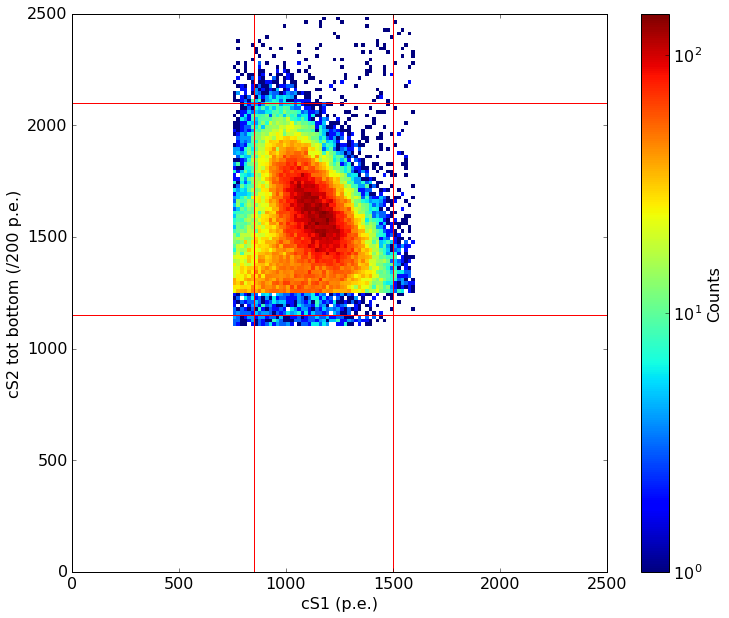

In [21]:
# We have to fit a Gaussian fonction to the ellipse in the red lines
from matplotlib.colors import LogNorm


plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200, bins=(150,150), range =([0,2500],[0,2500]),cmin=1,norm=LogNorm())
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
plt.axvline(850,color='red')
plt.axvline(1500,color='red')
plt.axhline(1150,color='red')
plt.axhline(2100,color='red')



plt.show()

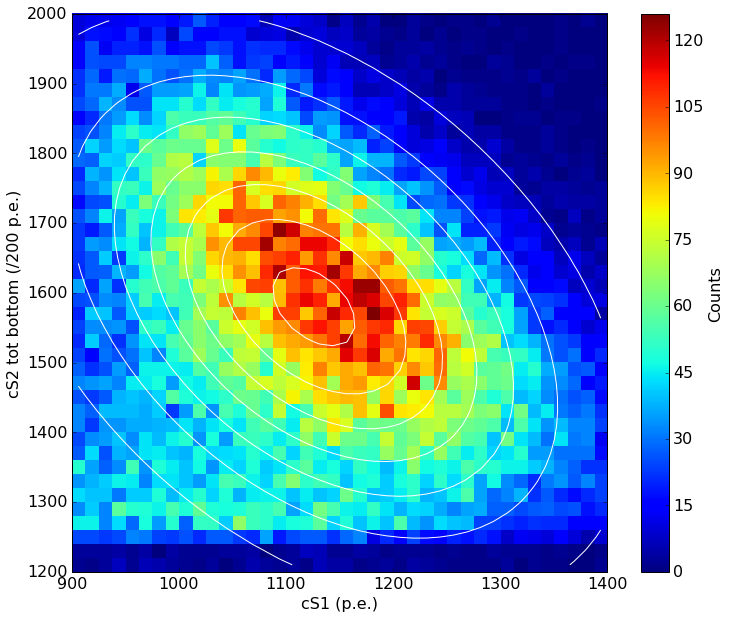

[  1.04242600e+02   1.12607782e+03   1.58009852e+03   1.14098500e+02
   2.08820968e+02  -4.19675475e-01   5.03243874e+00]


In [22]:
# Settings!
binsize = 40
range_s1 = (900,1400)
range_s2 = (1200,2000)

# This is the function to fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

s1s2hist = plt.hist2d(np.array(new_cs1),(np.array(new_cs2_tot_bottom)/200),
         bins=(binsize,binsize),range=(range_s1,range_s2))
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
hist_counts,hist_s1, hist_s2, _ = s1s2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_flat = []
y_flat = []
z_flat = []

# Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# Has been checked.

for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])
        
# twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):

initial_guess = (20,1140,1550,100,500,0.78,0)

popt, pcov = curve_fit(twoD_Gaussian, (x_flat, y_flat), z_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# For plotting purposes
data_fitted = np.array([twoD_Gaussian((x, y), *popt)
               for x in x_fit_1d
               for y in y_fit_1d]).flatten()


plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='w')


plt.show()

print(popt)

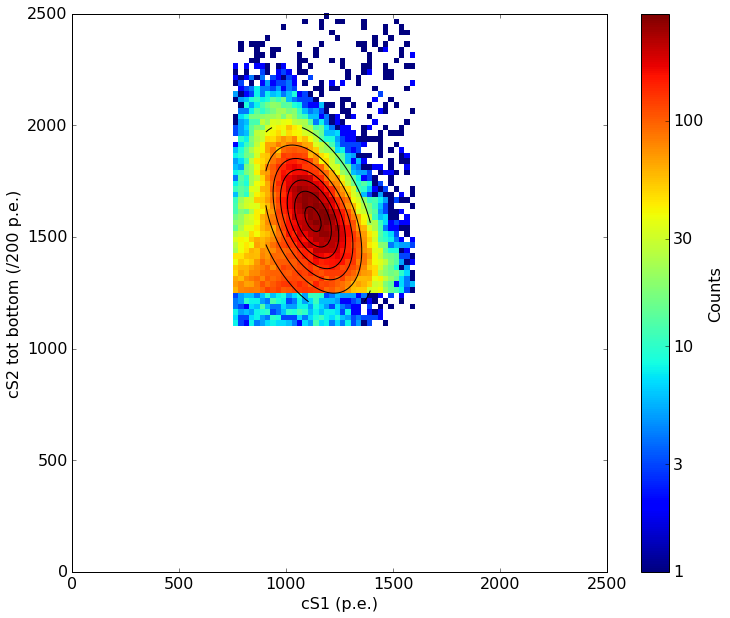

In [23]:

plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200,
           bins=(100,100),range=((0,2500),(0,2500)),cmin=1,norm=LogNorm())
cbar = plt.colorbar(label = 'Counts',ticks=[1,3,10,30,100])
cbar.set_ticklabels([1,3,10,30,100])
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
plt.contour(x_fit_1d, np.array(y_fit_1d), data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='black')




plt.show()

In [24]:
# We are moving to energy space!
mte1=popt[1]
mte2=popt[2]
energy_cs1= np.array(new_cs1)/popt[1]*662
energy_cs2=(np.array(new_cs2_tot_bottom)/200)/popt[2]*662
print(energy_cs1)
print(energy_cs2)

[ 680.93905401  645.99357601  674.31245752 ...,  798.42935396  838.18971683
  705.64015342]
[ 630.02111899  529.52117444  537.85927411 ...,  626.11154707  581.15984894
  547.41449465]


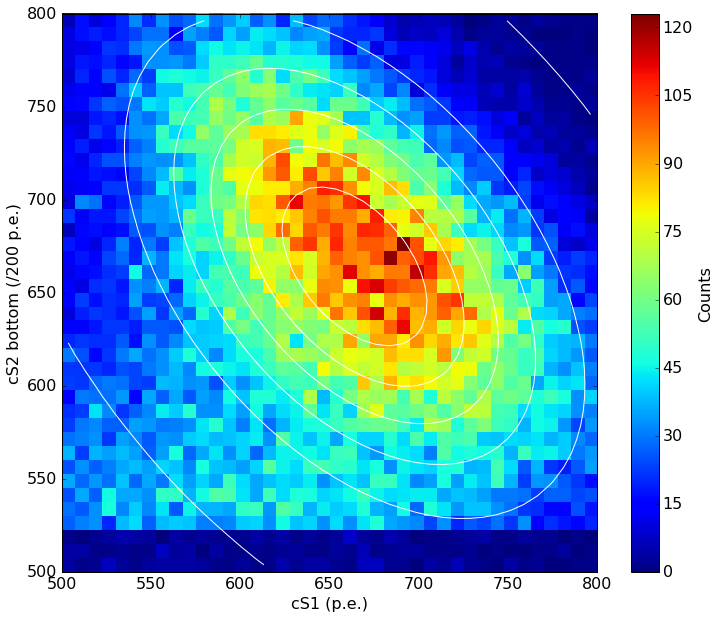

[  9.03797078e+01   6.64121173e+02   6.64161451e+02   6.93343256e+01
   7.28633345e+01  -4.71936656e-01   1.39304223e+01]


In [25]:
# Settings:
binsize = 40
range_s1 = (500,800)
range_s2 = (500,800)

# Better function!
def bivar(xdata_tuple, amplitude, xo,yo,sigma_x,sigma_y,rho,offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)  
    return offset + amplitude*np.exp((-1/(2*(1-rho**2)))*((x-xo)**2/(sigma_x**2) + 
                                                          (y-yo)**2/(sigma_y**2) -
                                                          2*rho*(x-xo)*(y-yo)/(sigma_x*sigma_y)) 
                                    )

s1s2hist = plt.hist2d(np.array(energy_cs1),np.array(energy_cs2), bins=(binsize,binsize),range=(range_s1,range_s2))
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 bottom (/200 p.e.)")

# hist_counts: binsize x binsize array of number of counts
# s1 / s2: binsize+1 array of edges

hist_counts,hist_s1, hist_s2, _ = s1s2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_flat = []
y_flat = []
z_flat = []

# Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# Has been checked.
for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])
        
# twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
initial_guess = (20,662,662,100,100,0.78,0)
popt, pcov = curve_fit(bivar, (x_flat, y_flat), z_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# For plotting purposes
data_fitted = np.array([bivar((x, y), *popt)
               for x in x_fit_1d
               for y in y_fit_1d]).flatten()


plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='w')



plt.show()
print(popt)


anticorrelation angle= -0.837824379939 rad


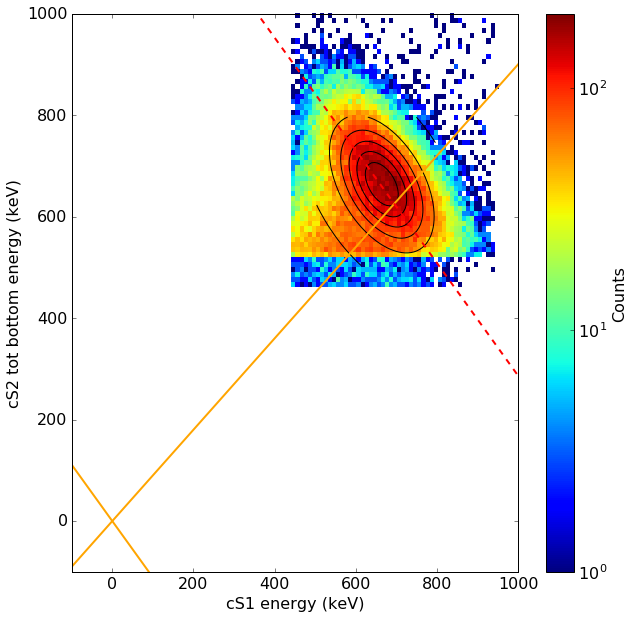

In [26]:
binsize=40
plt.figure(figsize=(10,10))
plt.hist2d(np.array(energy_cs1),np.array(energy_cs2),
           bins=(100,100),range=((0,1000),(0,1000)),cmin=1,norm=LogNorm())
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 energy (keV)")
plt.ylabel("cS2 tot bottom energy (keV)")
plt.contour(x_fit_1d, np.array(y_fit_1d), data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='black')


sigma_x  = popt[3]
sigma_y  = popt[4]
rho = popt[5]


theta=0.5*np.arctan(2*rho*(sigma_x*sigma_y)/(sigma_x**2-sigma_y**2))

theta=theta-np.pi/2 # Angle definition

print('anticorrelation angle=', theta,'rad')


x_list = [x for x in np.arange(-2000,2000,1.)]
v_axis = [-x*np.cos(theta)/np.sin(theta) for x in x_list]
u_axis = [x*np.tan(theta) for x in x_list]

c = 662.*np.cos(theta)-662.*np.sin(theta)

u_axis_2 = [x*np.tan(theta) + c/np.cos(theta) for x in x_list]
v_axis_2 = [-x*np.cos(theta)/np.sin(theta) + c/np.sin(theta) for x in x_list]

plt.plot(x_list,u_axis,color='orange',lw=2)
plt.plot(x_list,v_axis,color='orange',lw=2)
plt.plot(x_list,u_axis_2,color='red',lw=2,ls='--')

plt.xlim(-100,1000)
plt.ylim(-100,1000)


plt.show()

Projection of the energy along the large axis of the ellipse

anticorrelation angle= -0.837824379939 rad


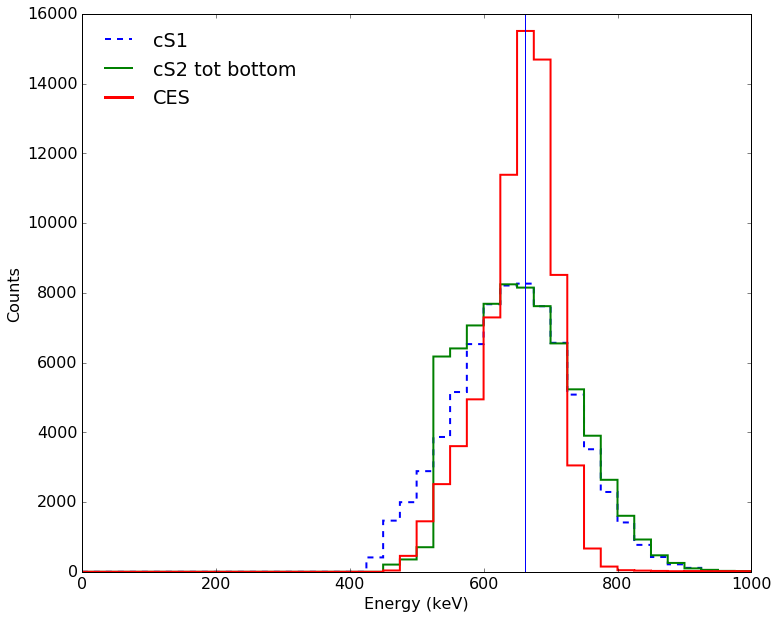

In [27]:
# http://2.bp.blogspot.com/-G-KLeae_EYU/TgdtpzntqvI/AAAAAAAABrI/Rv8Iea9zFVQ/s1600/Screen%2Bshot%2B2011-06-26%2Bat%2B1.33.51%2BPM.png

theta = 0.5*np.arctan(2*rho*(sigma_x*sigma_y)/(sigma_x**2-sigma_y**2))
theta=theta-np.pi/2 # Angle definition

print('anticorrelation angle=',theta,'rad')

# u = x cos(th) + y sin(th)
# v = y cos(th) - x sin(th)
peak_v = 662.*np.cos(theta)-662.*np.sin(theta)

# Parameters for plotting
myrange = (0,1000)
mybins = 40

# Produce histograms
plt.hist(np.array(energy_cs1),bins=mybins,histtype='step',label='cS1',range=myrange,linestyle='dashed',lw=2)
plt.hist(np.array(energy_cs2),bins=mybins,histtype='step',label='cS2 tot bottom',range=myrange,lw=2)
plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=mybins,
         histtype='step',label='CES',range=myrange,lw=2)

# Legend
p1,  = plt.plot(0,0,color='blue',linestyle='dashed',lw=2)
p2,  = plt.plot(0,0,color='green',lw=2)
p3,  = plt.plot(0,0,color='red',lw=3)
l1 = plt.legend([p1,p2,p3], ["cS1","cS2 tot bottom","CES"], loc='upper left',frameon=False)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.axvline(662)


plt.show()

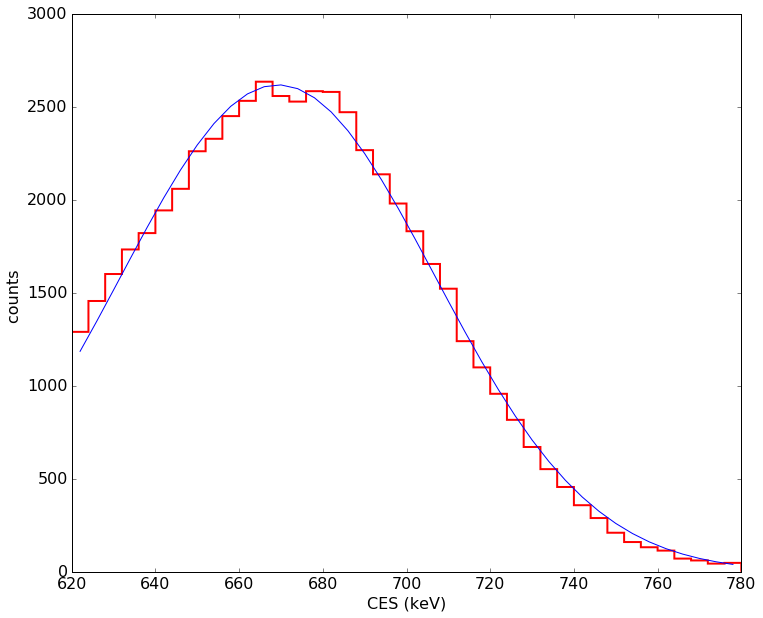

[ 2618.13291966   669.28656736   -37.56009259]
sigma_CES= -37.5600925916


In [28]:
# Fit an one dimentional Gaussian function to CES to determine the standard deviation
# Settings!
binsize = 40
myrange=(620,780)
mybins=40
# This is the function to fit
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p is the initial guess

CEShist = plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=mybins,
         histtype='step',label='CES',range=myrange,lw=2, color='red')


plt.xlabel("CES (keV)")
plt.ylabel("counts ")

hist_counts,hist_energy,_=CEShist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_energy[i+1]+hist_energy[i])/2
           for i in range(0,len(hist_energy)-1)]

x_flat = []
y_flat = []


#  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
#  Has been checked.

for i_x in range(len(x_fit_1d)):
    x_flat.append(x_fit_1d[i_x])
    y_flat.append(hist_counts[i_x])
        
#  oneD_Gaussian:

initial_guess = (400,662,100)

popt, pcov = curve_fit(gauss,x_flat, y_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

#  For plotting purposes
data_fitted = np.array([gauss(x, *popt)
               for x in x_fit_1d]).flatten()

plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'))

plt.show()

print(popt)
sigma_CES=popt[2]
print('sigma_CES=', popt[2])

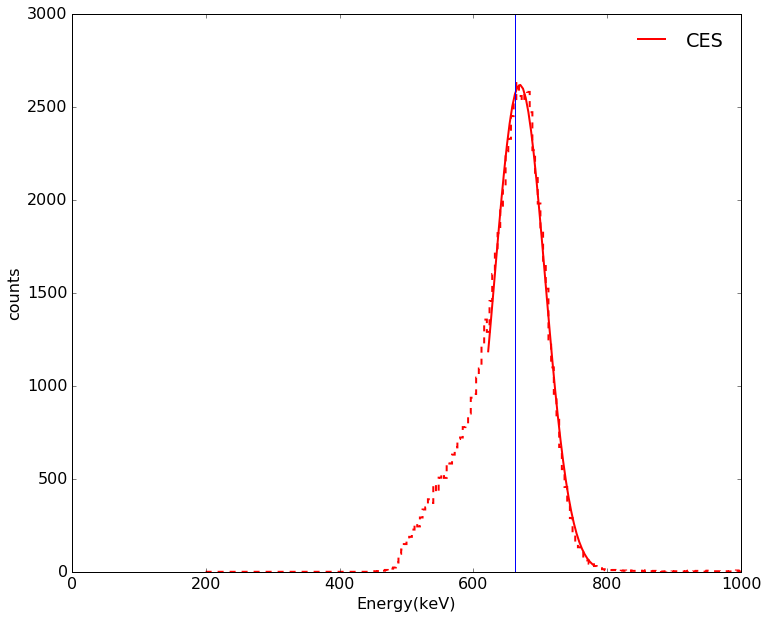

In [29]:
myrange=(200,1000)
binsize=40
plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=200,
         histtype='step',label='CES',range=myrange,lw=2, linestyle ='dashed',color='red')

plt.xlabel("Energy(keV)")
plt.ylabel("counts")
         
plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'),color='red', lw=2)
# Legend
p1,  = plt.plot(0,0,color='red',lw=2)

l1 = plt.legend([p1], ["CES"], loc='upper right',frameon=False)
plt.axvline (662)
# plt.axvline(662+37.7)
# plt.axvline(662-37.7)
plt.show()

In [30]:
sigma_CES=abs(sigma_CES)

 # Select events in the photopeak (662- 2* $\sigma$ < CES <662 + 2* $\sigma$)

In [31]:
CES=np.array(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)))
dataE2s=data[(CES>662-2*sigma_CES) & (CES<662+2*sigma_CES)]
CESselect2s= CES[(CES>662-2*sigma_CES)&(CES<662+2*sigma_CES)] 
len(CESselect2s)

62153

In [32]:
dataE2s.head()

,index,newcs1,newcs2,index,s1_area_channel_1,s1_area_channel_106,s1_area_channel_114,s1_area_channel_130,s1_area_channel_137,s1_area_channel_140,...,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z,phi,r
4,4,1158.293602,300753.909481,4,0.0,3.169986,3.029374,10.192683,4.210809,11.822699,...,3.403345,849.740295,0.255484,344215.21875,0.366078,6.929379,-0.901130,-6.002091,1.44148,6.987727
22,22,1098.850509,252778.134836,22,0.0,20.446175,16.610564,13.278718,17.802317,7.810788,...,0.000000,1073.199097,0.160233,270263.31250,0.366614,2.641243,9.601695,-15.863226,2.87315,9.958349
29,29,1147.021603,256758.503109,29,0.0,15.923173,20.612660,8.100842,16.188589,9.335491,...,4.594101,1247.790649,0.145457,318191.28125,0.349450,3.449152,7.612994,-18.272846,2.7162,8.357890
42,42,1180.467104,276985.478157,42,0.0,12.362228,20.846734,1.787417,29.568586,11.809240,...,0.000000,1143.417236,0.120380,272065.09375,0.373556,11.838983,3.324859,-20.330551,1.84458,12.296999
55,55,1136.810747,286751.131700,55,0.0,6.942247,12.798352,4.406573,17.872820,8.767524,...,0.000000,957.149719,0.178900,316809.31250,0.347038,5.872881,8.358757,-11.779012,2.52912,10.215652


# Find the S1 values in the middle of the TPC (z~-15 cm and r~0 cm$^2$)

In [34]:
# Values of S1 in the middle of the TPC
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)

number_list = []
s1_mean_values=[]

box_cut=[]

for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1'])/len(dataE2s[box_cut])))
            
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break
       

s1_mean_values=np.array(s1_mean_values)
s1_mean_values=s1_mean_values.reshape(len(z_slices)-1,len(r_slices)-1)    
s1_mean_tpc=s1_mean_values[8][0] # In the middle of the TPC (z~15, r~0), values=1
print('values of S1 in the middle of the TPC= ',s1_mean_values[8][0], 'pe')

values of S1 in the middle of the TPC=  1235.17318672 pe


# Per PMT 

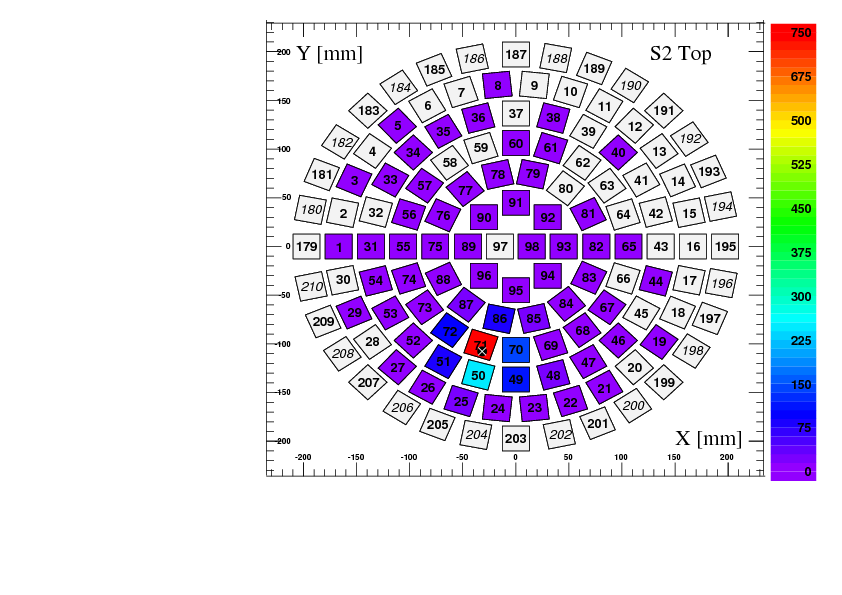

In [35]:
Image('https://inspirehep.net/record/1122618/files/fig10_s2.png')

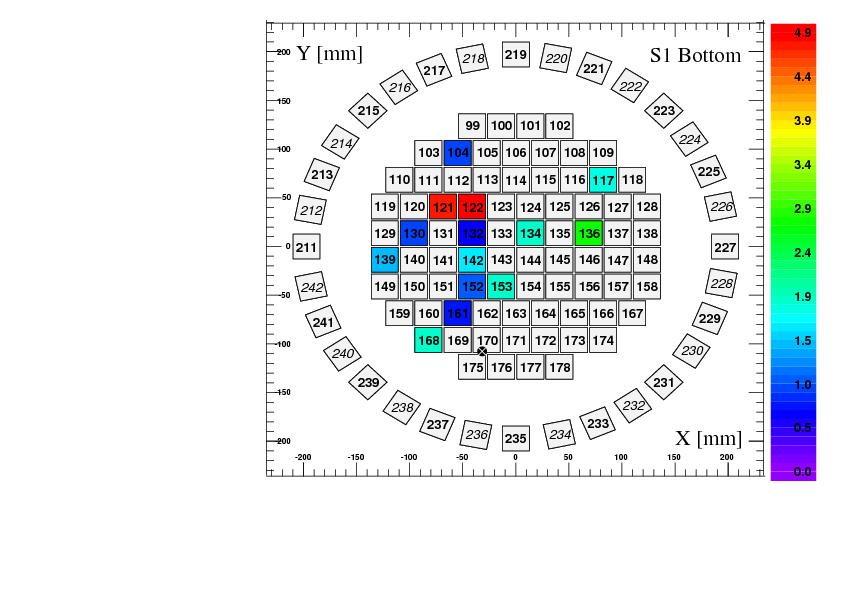

In [36]:
Image('https://inspirehep.net/record/1122618/files/fig10_s1.png')


# Bottom array of PMTs

# PMT 144

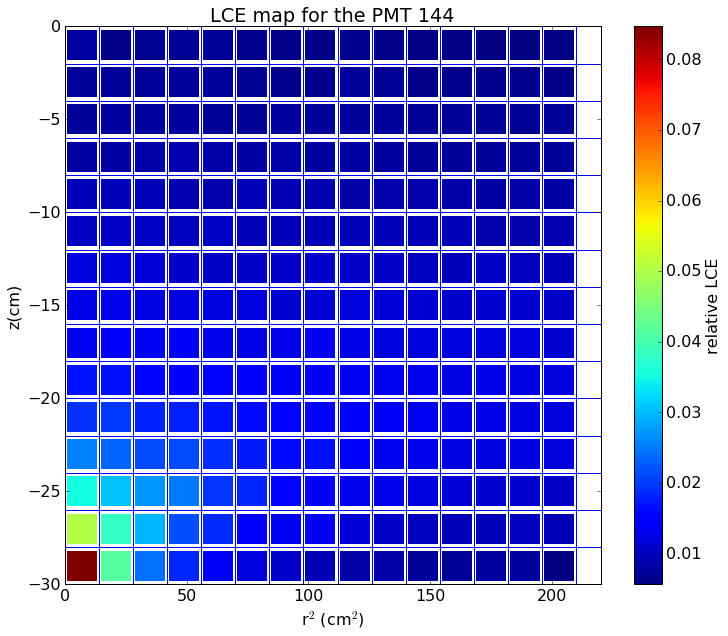

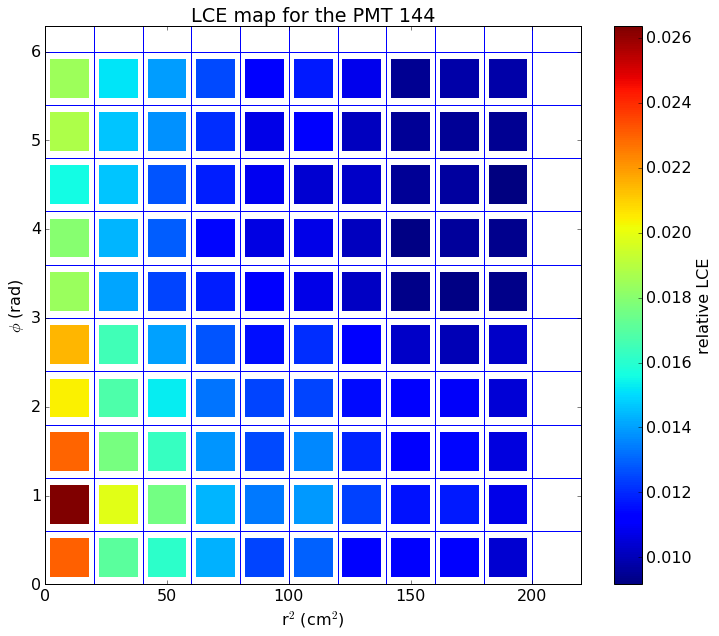

In [57]:
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)

number_list = []
s1_mean_values=[]

box_cut=[]
ri=[]
zi=[]
for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_144']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
        
        ri.append((r_slices[j]+r_slices[j+1])/2)
        zi.append((z_slices[i]+z_slices[i+1])/2)
        
        
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break
       

s1_mean_values=np.array(s1_mean_values)
s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(z_slices)-1)    

result144=ri,zi,s1_mean_values

plt.scatter(result144[0],result144[1], c=result144[2], edgecolor='none', s=900, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('z(cm)')
plt.ylim(-30,0)
plt.xlim(0,220)
plt.title('LCE map for the PMT 144')
for k in range (0,220,14):
    plt.axvline(k)
for m in range (0,-32,-2):
    plt.axhline(m)
plt.show()

phi_slices = np.arange(0,2*np.pi,0.6)
r_slices=np.arange(0,220,20)

number_list = []
s1_mean_values=[]
resultphi_2s=[]
box_cut=[]
ri=[]
phii=[]


for i, phi in enumerate(phi_slices):
    for j, r in enumerate(r_slices):    
        box_cut=(((dataE2s['phi'])>phi_slices[i]) & ((dataE2s['phi'])<phi_slices[i+1]) &
                  ((dataE2s['r']**2)>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        number_list.append(len(dataE2s[box_cut]))    
        
        
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
             s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_144']/s1_mean_tpc)
                               /len(dataE2s[box_cut])))
                
        ri.append((r_slices[j]+r_slices[j+1])/2)
        phii.append((phi_slices[i]+phi_slices[i+1])/2)

        if j == (len(r_slices)-2):
            break
    if i ==(len(phi_slices)-2):
        break


s1_mean_values=np.array(s1_mean_values)
s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(r_slices)-1)   

resultphi144=ri,phii,s1_mean_values

plt.scatter(resultphi144[0],resultphi144[1], c=resultphi144[2], edgecolor='none', s=1500, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('$\phi$ (rad)')
plt.ylim(0,2*np.pi)
plt.xlim(0,220)

for k in range (0,220,20):
    plt.axvline(k)

plt.axhline(0.6)
plt.axhline(2*0.6)
plt.axhline(3*0.6)
plt.axhline(4*0.6)
plt.axhline(5*0.6)
plt.axhline(6*0.6)
plt.axhline(7*0.6)
plt.axhline(8*0.6)
plt.axhline(9*0.6)
plt.axhline(10*0.6)

plt.title('LCE map for the PMT 144')

plt.show()


# PMT 141

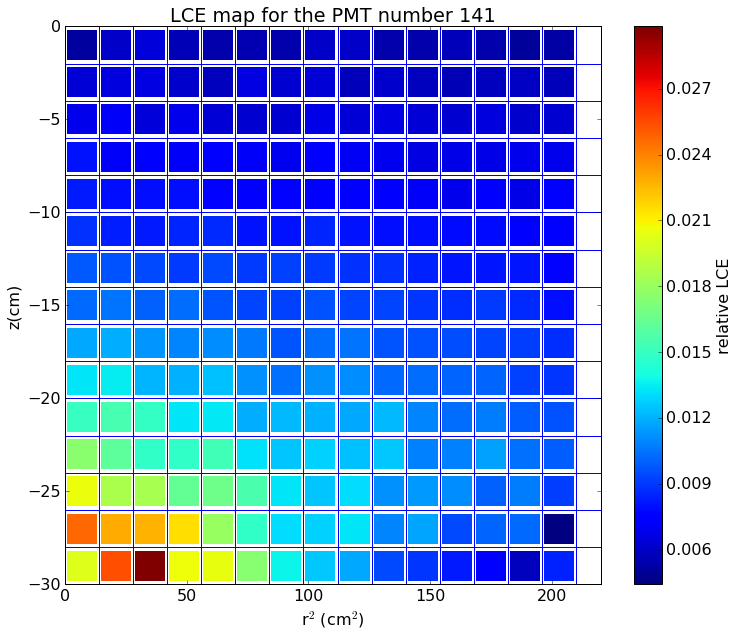

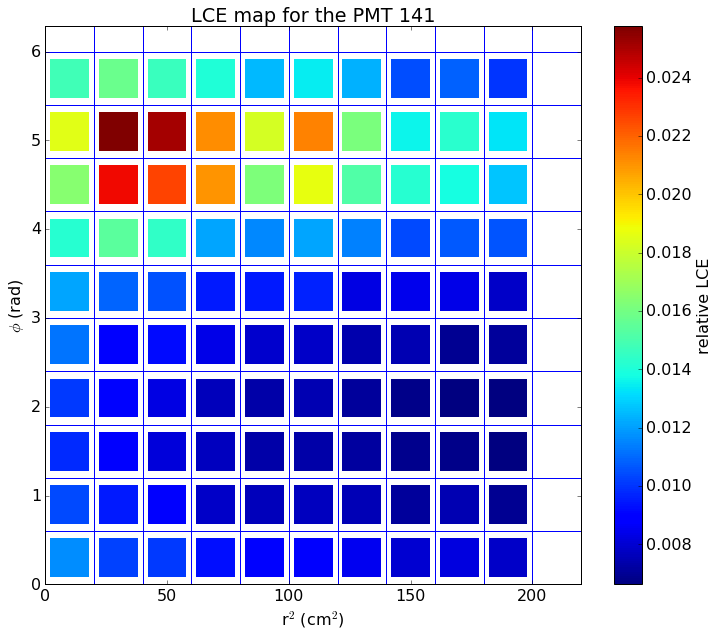

In [58]:
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)
number_list = []
s1_mean_values=[]
box_cut=[]
ri=[]
zi=[]
for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_141']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
        
        ri.append((r_slices[j]+r_slices[j+1])/2)
        zi.append((z_slices[i]+z_slices[i+1])/2)
        
        
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break

s1_mean_values=np.array(s1_mean_values)
s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(z_slices)-1)    

result141=ri,zi,s1_mean_values

plt.scatter(result141[0],result141[1], c=result141[2], edgecolor='none', s=900, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('z(cm)')
plt.ylim(-30,0)
plt.xlim(0,220)
plt.title('LCE map for the PMT number 141')
for k in range (0,220,14):
    plt.axvline(k)
for m in range (0,-32,-2):
    plt.axhline(m)
plt.show()


phi_slices = np.arange(0,2*np.pi,0.6)
r_slices=np.arange(0,220,20)
# phi_slices and r_slices must have the same length

number_list = []
s1_mean_values=[]
resultphi_2s=[]
box_cut=[]
ri=[]
phii=[]


for i, phi in enumerate(phi_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=(((dataE2s['phi'])>phi_slices[i]) & ((dataE2s['phi'])<phi_slices[i+1]) &
                  ((dataE2s['r']**2)>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        

        number_list.append(len(dataE2s[box_cut])) 
        
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_141']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
    
        ri.append((r_slices[j]+r_slices[j+1])/2)
        phii.append((phi_slices[i]+phi_slices[i+1])/2)

            
        if j == (len(r_slices)-2):
            break
    if i ==(len(phi_slices)-2):
        break
        


s1_mean_values=np.array(s1_mean_values)

s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(r_slices)-1)    
resultphi141=ri,phii,s1_mean_values

plt.scatter(resultphi141[0],resultphi141[1], c=resultphi141[2], edgecolor='none', s=1500, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('$\phi$ (rad)')
plt.ylim(0,2*np.pi)
plt.xlim(0,220)
plt.title('LCE map for the PMT 141')
for k in range (0,220,20):
    plt.axvline(k)

plt.axhline(0.6)
plt.axhline(2*0.6)
plt.axhline(3*0.6)
plt.axhline(4*0.6)
plt.axhline(5*0.6)
plt.axhline(6*0.6)
plt.axhline(7*0.6)
plt.axhline(8*0.6)
plt.axhline(9*0.6)
plt.axhline(10*0.6)
plt.show()


# Top Array of PMTs

# PMT 97

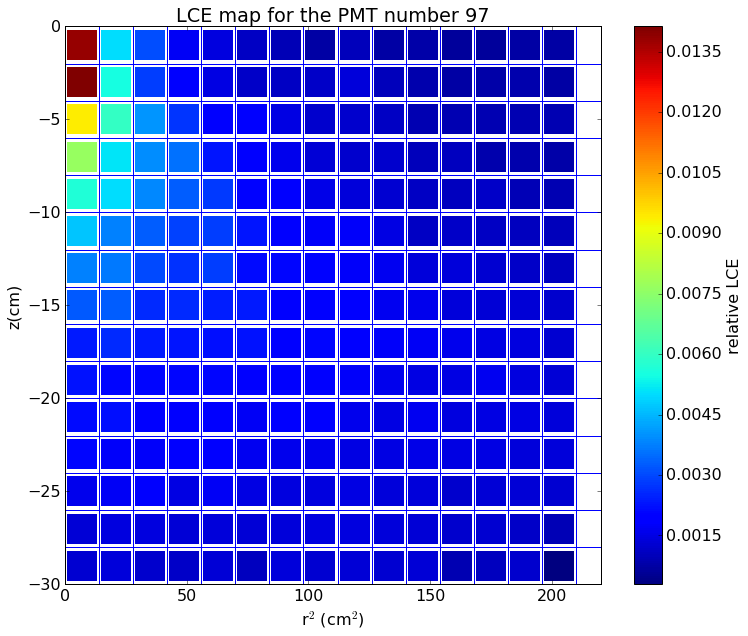

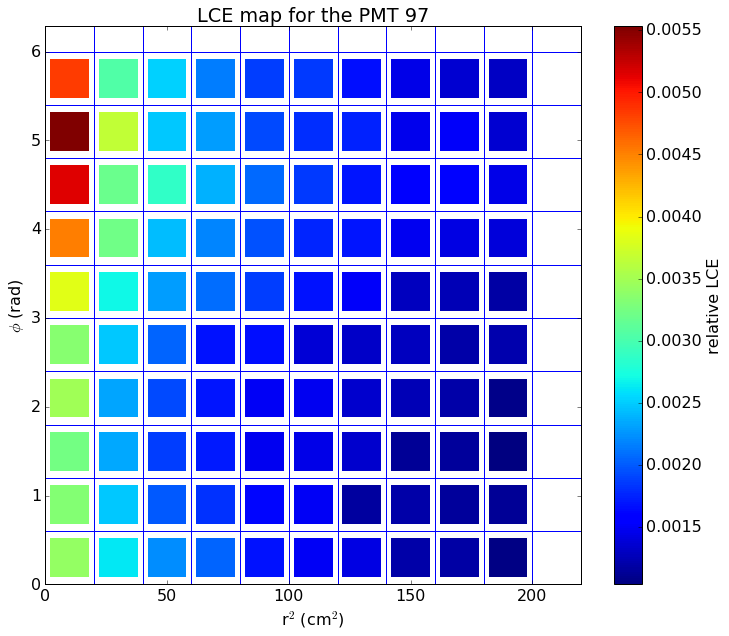

In [60]:
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)
number_list = []
s1_mean_values=[]
box_cut=[]
ri=[]
zi=[]
for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_97']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
        
        ri.append((r_slices[j]+r_slices[j+1])/2)
        zi.append((z_slices[i]+z_slices[i+1])/2)
        
        
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break

s1_mean_values=np.array(s1_mean_values)
s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(z_slices)-1)    

result97=ri,zi,s1_mean_values

plt.scatter(result97[0],result97[1], c=result97[2], edgecolor='none', s=900, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('z(cm)')
plt.ylim(-30,0)
plt.xlim(0,220)
plt.title('LCE map for the PMT number 97')
for k in range (0,220,14):
    plt.axvline(k)
for m in range(0,-32,-2):
    plt.axhline(m)
plt.show()

phi_slices = np.arange(0,2*np.pi,0.6)
r_slices=np.arange(0,220,20)
# phi_slices and r_slices must have the same length

number_list = []
s1_mean_values=[]
box_cut=[]
ri=[]
phii=[]


for i, phi in enumerate(phi_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=(((dataE2s['phi'])>phi_slices[i]) & ((dataE2s['phi'])<phi_slices[i+1]) &
                  ((dataE2s['r']**2)>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        

        number_list.append(len(dataE2s[box_cut])) 
        
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_97']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
    
        ri.append((r_slices[j]+r_slices[j+1])/2)
        phii.append((phi_slices[i]+phi_slices[i+1])/2)

            
        if j == (len(r_slices)-2):
            break
    if i ==(len(phi_slices)-2):
        break
        


s1_mean_values=np.array(s1_mean_values)

s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(r_slices)-1)    
resultphi97=ri,phii,s1_mean_values

plt.scatter(resultphi97[0],resultphi97[1], c=resultphi97[2], edgecolor='none', s=1500, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('$\phi$ (rad)')
plt.xlim(0,220)
plt.ylim(0,2*np.pi)
plt.title('LCE map for the PMT 97')
for k in range (0,220,20):
    plt.axvline(k)

plt.axhline(0.6)
plt.axhline(2*0.6)
plt.axhline(3*0.6)
plt.axhline(4*0.6)
plt.axhline(5*0.6)
plt.axhline(6*0.6)
plt.axhline(7*0.6)
plt.axhline(8*0.6)
plt.axhline(9*0.6)
plt.axhline(10*0.6)
plt.show()

# PMT 75

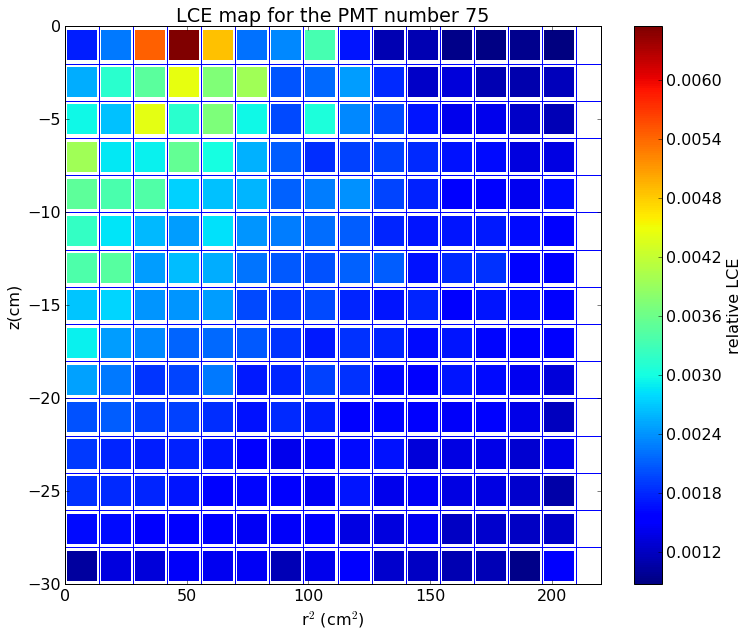

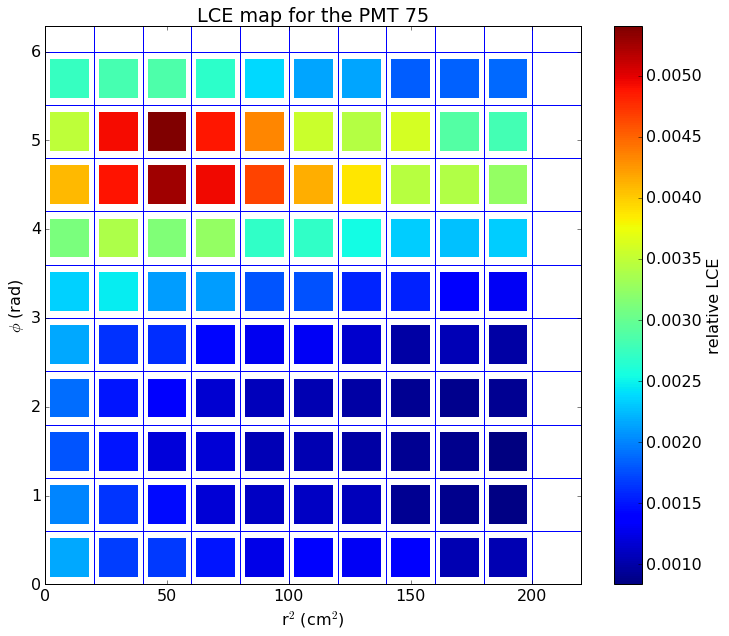

In [61]:
z_slices = np.arange(0,-32,-2)
r_slices=np.arange(0,220,14)
number_list = []
s1_mean_values=[]
box_cut=[]
ri=[]
zi=[]
for i, z in enumerate(z_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=((dataE2s['z']>z_slices[i+1]) & (dataE2s['z']<z_slices[i]) &
                  ((dataE2s['r']**2 )>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        
        number_list.append(len(dataE2s[box_cut])) 
        
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_75']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
        
        ri.append((r_slices[j]+r_slices[j+1])/2)
        zi.append((z_slices[i]+z_slices[i+1])/2)
        
        
        if j ==(len(r_slices)-2):
            break
            
    if i == (len(z_slices)-2):
        break

s1_mean_values=np.array(s1_mean_values)
s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(z_slices)-1)    

result75=ri,zi,s1_mean_values

plt.scatter(result75[0],result75[1], c=result75[2], edgecolor='none', s=900, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('z(cm)')
plt.ylim(-30,0)
plt.xlim(0,220)
plt.title('LCE map for the PMT number 75')
for k in range (0,220,14):
    plt.axvline(k)
for m in range (0,-32,-2):
    plt.axhline(m)
plt.show()

phi_slices = np.arange(0,2*np.pi,0.6)
r_slices=np.arange(0,220,20)
# phi_slices and r_slices must have the same length

number_list = []
s1_mean_values=[]
box_cut=[]
ri=[]
phii=[]


for i, phi in enumerate(phi_slices):

    for j, r in enumerate(r_slices):
        
        box_cut=(((dataE2s['phi'])>phi_slices[i]) & ((dataE2s['phi'])<phi_slices[i+1]) &
                  ((dataE2s['r']**2)>r_slices[j]) & ((dataE2s['r']**2)<r_slices[j+1])) 
        

        number_list.append(len(dataE2s[box_cut])) 
        if len(dataE2s[box_cut])==0: 
            print('error, the box don t contain any event, increase the slice side')
            break
        else :
            s1_mean_values.append((np.sum(dataE2s[box_cut]['s1_area_channel_75']/s1_mean_tpc)
                                   /len(dataE2s[box_cut])))
    
        ri.append((r_slices[j]+r_slices[j+1])/2)
        phii.append((phi_slices[i]+phi_slices[i+1])/2)

            
        if j == (len(r_slices)-2):
            break
    if i ==(len(phi_slices)-2):
        break
        


s1_mean_values=np.array(s1_mean_values)

s1_mean_values=s1_mean_values.reshape(len(r_slices)-1,len(r_slices)-1)    
resultphi75=ri,phii,s1_mean_values

plt.scatter(resultphi75[0],resultphi75[1], c=resultphi75[2], edgecolor='none', s=1500, marker=',')
plt.colorbar(label='relative LCE')
plt.xlabel('r$^2$ (cm$^2$)')
plt.ylabel('$\phi$ (rad)')
plt.xlim(0,220)
plt.ylim(0,2*np.pi)
for k in range (0,220,20):
    plt.axvline(k)

plt.axhline(0.6)
plt.axhline(2*0.6)
plt.axhline(3*0.6)
plt.axhline(4*0.6)
plt.axhline(5*0.6)
plt.axhline(6*0.6)
plt.axhline(7*0.6)
plt.axhline(8*0.6)
plt.axhline(9*0.6)
plt.axhline(10*0.6)
plt.title('LCE map for the PMT 75')
plt.show()